# **DISCO: Data Mining in Information System Competition**



## **Association Rules**

### **Objectives**

Analisis ini bertujuan untuk mengeksplorasi pola hubungan tersembunyi antar karakteristik UMKM melalui pendekatan *association rules*. Dengan memanfaatkan algoritma Apriori, studi ini berupaya mengidentifikasi kombinasi fitur yang sering muncul bersama pada kelompok UMKM dan memahami bagaimana karakteristik tersebut dapat saling berkaitan dalam konteks performa dan operasional usaha.

### **1. Data Preparation**

#### Langkah-langkah awal:

* Menghapus kolom yang tidak relevan seperti `id_umkm`, `nama_usaha`, dan `kapasitas_produksi`.
* Konversi semua kolom numerik ke tipe numerik yang valid untuk memastikan tidak ada kesalahan format.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

# Load dataset
data = pd.read_csv('dataset_edit.csv')
data

d:\Anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,id_umkm,nama_usaha,jenis_usaha,tenaga_kerja_perempuan,tenaga_kerja_laki_laki,aset,omset,marketplace,kapasitas_produksi,status_legalitas,tahun_berdiri,laba,biaya_karyawan,jumlah_pelanggan
0,28828567,UD. Alif Pamungkas,Kesehatan,1,56,5497149,3347794,Tokopedia,479,Belum Terdaftar,2015,-2149355,171000000,479
1,28828568,UD. Zidanar Panji,Perdagangan,5,44,7398384,39969661,Bukalapak,464,Terdaftar,2014,32571277,147000000,464
2,28828569,UD. Winda Jayengprana,unknown,74,51,8881762,25253355,Website Sendiri,383,Belum Terdaftar,2000,16371593,375000000,383
3,28828570,UD. Damaris Satria,Jasa,89,5,9576178,20700389,Website Sendiri,986,Belum Terdaftar,2003,11124211,282000000,986
4,28828571,UD. Qasya Wiratama,Jasa,91,59,9456853,4820810,Lazada,314,Belum Terdaftar,2002,-4636043,450000000,314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13559,288222126,UD. Syana Ilir Rian,Jasa,62,63,6854562,48239150,Website Sendiri,162,Belum Terdaftar,2003,41384588,375000000,162
13560,288222127,UD. Bela Widhi,Pendidikan,70,50,804787,35210634,Website Sendiri,180,Terdaftar,2012,34405847,360000000,180
13561,288222128,UD. Bayu Alam,Kesehatan,50,37,8211715,8874364,Lazada,802,Terdaftar,2009,662649,261000000,802
13562,288222129,UD. Olla Sudharmo Udin,Pendidikan,11,NaN,6217989,41510653,Website Sendiri,122,Belum Terdaftar,2009,35292664,132000000,122


In [2]:
# 1. Drop kolom ID/nama
df = data.copy()
df_clean = df.drop(['id_umkm', 'nama_usaha', 'kapasitas_produksi'], axis=1)

In [3]:
# 2. Konversi kolom numerik
numeric_columns = [
    'tenaga_kerja_perempuan',
    'tenaga_kerja_laki_laki',
    'aset',
    'omset',
    'laba',
    'tahun_berdiri',
    'biaya_karyawan',
    'jumlah_pelanggan'
]
for col in numeric_columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

In [4]:
# 3. Pisahkan kolom numerik dan kategorik
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns

### **2. Data Cleaning & Imputation**

#### Imputasi Kolom Numerik

* Menggunakan **IterativeImputer** untuk memperkirakan nilai hilang pada fitur numerik secara multivariat.

#### Imputasi Kolom Kategorik

* Menggunakan model **Random Forest Classifier** untuk mengisi nilai hilang pada kolom kategorikal dengan prediksi berbasis pola data yang sudah lengkap.

In [5]:
# 4. Imputasi numerik dengan IterativeImputer
imp_num = IterativeImputer(random_state=42)
df_clean[numerical_cols] = imp_num.fit_transform(df_clean[numerical_cols])

In [6]:
# 5. Imputasi kategorik dengan RandomForestClassifier
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        not_null = df_clean[df_clean[col].notnull()]
        null = df_clean[df_clean[col].isnull()]

        rf = RandomForestClassifier()
        rf.fit(not_null.drop(columns=categorical_cols), not_null[col])
        df_clean.loc[df_clean[col].isnull(), col] = rf.predict(null.drop(columns=categorical_cols))

### **3. Feature Transformation: Binarisasi**

* Untuk dapat digunakan dalam algoritma Apriori, semua fitur numerik dikonversi menjadi bentuk **biner** berdasarkan nilai **median** masing-masing kolom.
* Misalnya, `aset_high = aset > median(aset)`

In [7]:
# 6. Binarisasi nilai numerik (berdasarkan median)
for col in numeric_columns:
    median_val = df_clean[col].median()
    df_clean[col + '_high'] = df_clean[col] > median_val

binary_cols = [col + '_high' for col in numeric_columns]
df_bin = df_clean[binary_cols].copy()
df_bin = df_bin.astype(int)

### **4. Frequent Itemsets with Apriori**

* Mengidentifikasi kombinasi fitur yang sering muncul bersama menggunakan algoritma **Apriori**.
* Threshold minimum support ditetapkan sebesar **0.1**.

In [8]:
# 7. Apriori Algorithm
frequent_itemsets = apriori(df_bin, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

d:\Anaconda\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### **5. Rule Generation**

* Menghasilkan **aturan asosiasi** dari itemsets yang sering muncul.
* Digunakan metrik **confidence ≥ 0.7** dan dievaluasi dengan **lift**.

In [9]:
# 8. Top Rules dan Visualisasi
top_rules = rules.sort_values(by='lift', ascending=False).head(10)
top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
89,"(tenaga_kerja_perempuan_high, tenaga_kerja_lak...","(biaya_karyawan_high, omset_high)",0.114052,0.947336,3.820894
90,"(tenaga_kerja_perempuan_high, tenaga_kerja_lak...","(biaya_karyawan_high, laba_high)",0.114052,0.949080,3.819976
71,"(tenaga_kerja_laki_laki_high, laba_high)","(biaya_karyawan_high, omset_high)",0.175096,0.715361,2.885270
68,"(biaya_karyawan_high, omset_high)","(tenaga_kerja_laki_laki_high, laba_high)",0.175096,0.706215,2.885270
70,"(tenaga_kerja_laki_laki_high, omset_high)","(biaya_karyawan_high, laba_high)",0.175096,0.713427,2.871493
69,"(biaya_karyawan_high, laba_high)","(tenaga_kerja_laki_laki_high, omset_high)",0.175096,0.704748,2.871493
55,"(tenaga_kerja_perempuan_high, laba_high)","(biaya_karyawan_high, omset_high)",0.175981,0.706422,2.849214
56,"(biaya_karyawan_high, omset_high)","(tenaga_kerja_perempuan_high, laba_high)",0.175981,0.709783,2.849214
57,"(biaya_karyawan_high, laba_high)","(tenaga_kerja_perempuan_high, omset_high)",0.175981,0.708309,2.843296
54,"(tenaga_kerja_perempuan_high, omset_high)","(biaya_karyawan_high, laba_high)",0.175981,0.706422,2.843296


### **6. Visualization**

* Plot interaktif untuk menampilkan hubungan antara **support** dan **confidence**, dengan ukuran titik mencerminkan **lift**.

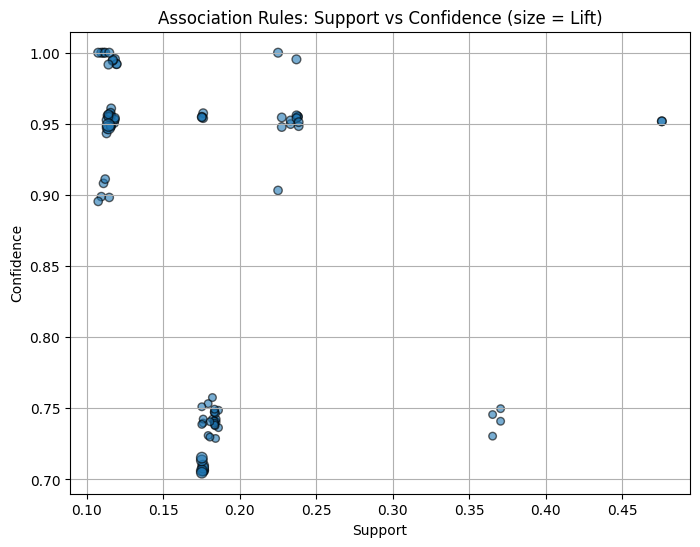

In [10]:
# 9. Grafik: Support vs Confidence (size = Lift)
plt.figure(figsize=(8, 6))
plt.scatter(rules['support'], rules['confidence'],
            s=rules['lift'] * 20, alpha=0.6, edgecolors='k')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (size = Lift)')
plt.grid(True)
plt.show()

### **Output**

In [11]:
# Sort semua rules berdasarkan lift tertinggi
rules_sorted = rules.sort_values(by='lift', ascending=False)

# Ekspor ke CSV
rules_sorted.to_csv("Association Rules - UMKM.csv", index=False)

### **Kesimpulan**

Analisis ini mampu mengungkap **aturan tersembunyi** dalam karakteristik UMKM yang tidak langsung terlihat melalui eksplorasi deskriptif biasa. Dengan kombinasi teknik *preprocessing*, *binarization*, dan *association mining*, kita dapat mengenali **pola-pola khas efisiensi usaha**, ketidakwajaran performa, dan potensi anomali dalam struktur data UMKM. Temuan ini bisa digunakan sebagai acuan awal untuk membedakan antara UMKM yang **efisien** dan **tidak efisien**, serta mendukung pengambilan kebijakan berbasis data.
